# Light GBM

Use tree-based algorithms since they are powerful and do not impose strict assumptions on features like linearity or independence. Light GBM is a fast algorithm with lower memory usage.

In [1]:
!pip install lightgbm

In [2]:
#conda install numpy

Import libraries

In [3]:
import pandas as pd
import numpy as np
from datetime  import datetime  
from datetime import timedelta  
import lightgbm as lgb
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns
#import boto3
#import sagemaker
#from sagemaker import get_execution_role


Read data

In [4]:
X_train = pd.read_pickle('../01_preprocessed_data/X_train.pkl')
y_train = pd.read_pickle('../01_preprocessed_data/y_train.pkl')
X_val = pd.read_pickle('../01_preprocessed_data/X_val.pkl')
y_val = pd.read_pickle('../01_preprocessed_data/y_val.pkl')
X_test = pd.read_pickle('../01_preprocessed_data/X_test.pkl')



In [5]:
#role = get_execution_role()
#bucket='sagemaker-eu-central-1-594657351600'
#prefix = 'kaggle-m5/00_data'

#data_location = 's3://{}/{}/{}'.format(bucket, prefix, 'sample_submission.csv')
data_location = '../00_data/sample_submission.csv'
submission = pd.read_csv(data_location)

Set parameters of the light GBM and select features to fit.

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)


(42644016, 35)
(1706991, 35)
(853720, 35)
(42644016, 1)
(1706991, 1)


In [7]:
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'poisson',
        'n_jobs': -1,
        'seed': 0,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75}
not_features = ['d', 'demand', 'date', 'start_date']

In [8]:
features = X_test.columns[~X_test.columns.isin(not_features)]

In [9]:
train_set = lgb.Dataset(X_train[features], y_train) #, categorical_feature = categorical_features)
val_set = lgb.Dataset(X_val[features], y_val)#,  categorical_feature = categorical_features)

Train the model

In [10]:
model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 50, 
                  valid_sets = [train_set, val_set], verbose_eval = 100)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.67335	valid_1's rmse: 2.23878
[200]	training's rmse: 2.60079	valid_1's rmse: 2.22982
[300]	training's rmse: 2.5557	valid_1's rmse: 2.22629
Early stopping, best iteration is:
[338]	training's rmse: 2.54205	valid_1's rmse: 2.22245


Calculate the RMSE on the validation set

In [12]:
val_pred = model.predict(X_val[features])
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
X_val['demand'] = y_val
X_val['demand_pred'] = val_pred
X_val['abs_difference'] = abs(X_val['demand'] - X_val['demand_pred'])
print(f'Our val rmse score is {val_score}')
y_test = model.predict(X_test[features])
X_test['demand'] = y_test


Our val rmse score is 2.2224452839560414


In [13]:
print(f'Our val mae score is {metrics.mean_absolute_error(val_pred, y_val)}')

Our val mae score is 1.0582439104147365


We look at the mean absolute error by forecastablity in order to indestand what category needs more improvement for prediction.

In [14]:
X_val.groupby(['demand_type'])['demand_type', 'abs_difference'].agg(['mean']).reset_index()

,demand_type,abs_difference
,,mean
0,erratic,3.502241
1,intermittent,0.705681
2,lumpy,1.576801
3,smooth,2.766641


Text(0.5, 0, 'absolute error')

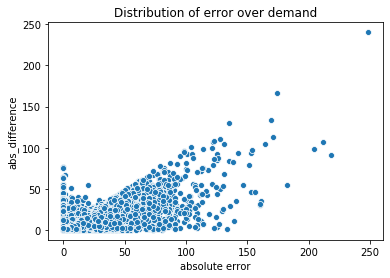

In [15]:
demans_vs_error = sns.scatterplot(x=X_val['demand'], y=X_val['abs_difference'])
demans_vs_error.set_title('Distribution of error over demand')
demans_vs_error.set_xlabel('absolute error')

Surprisingly smooth time series has a large mean absolute error. Erratic time series has a large mean absolute error; typically time series of this type is difficult to predict.

## Feature importance

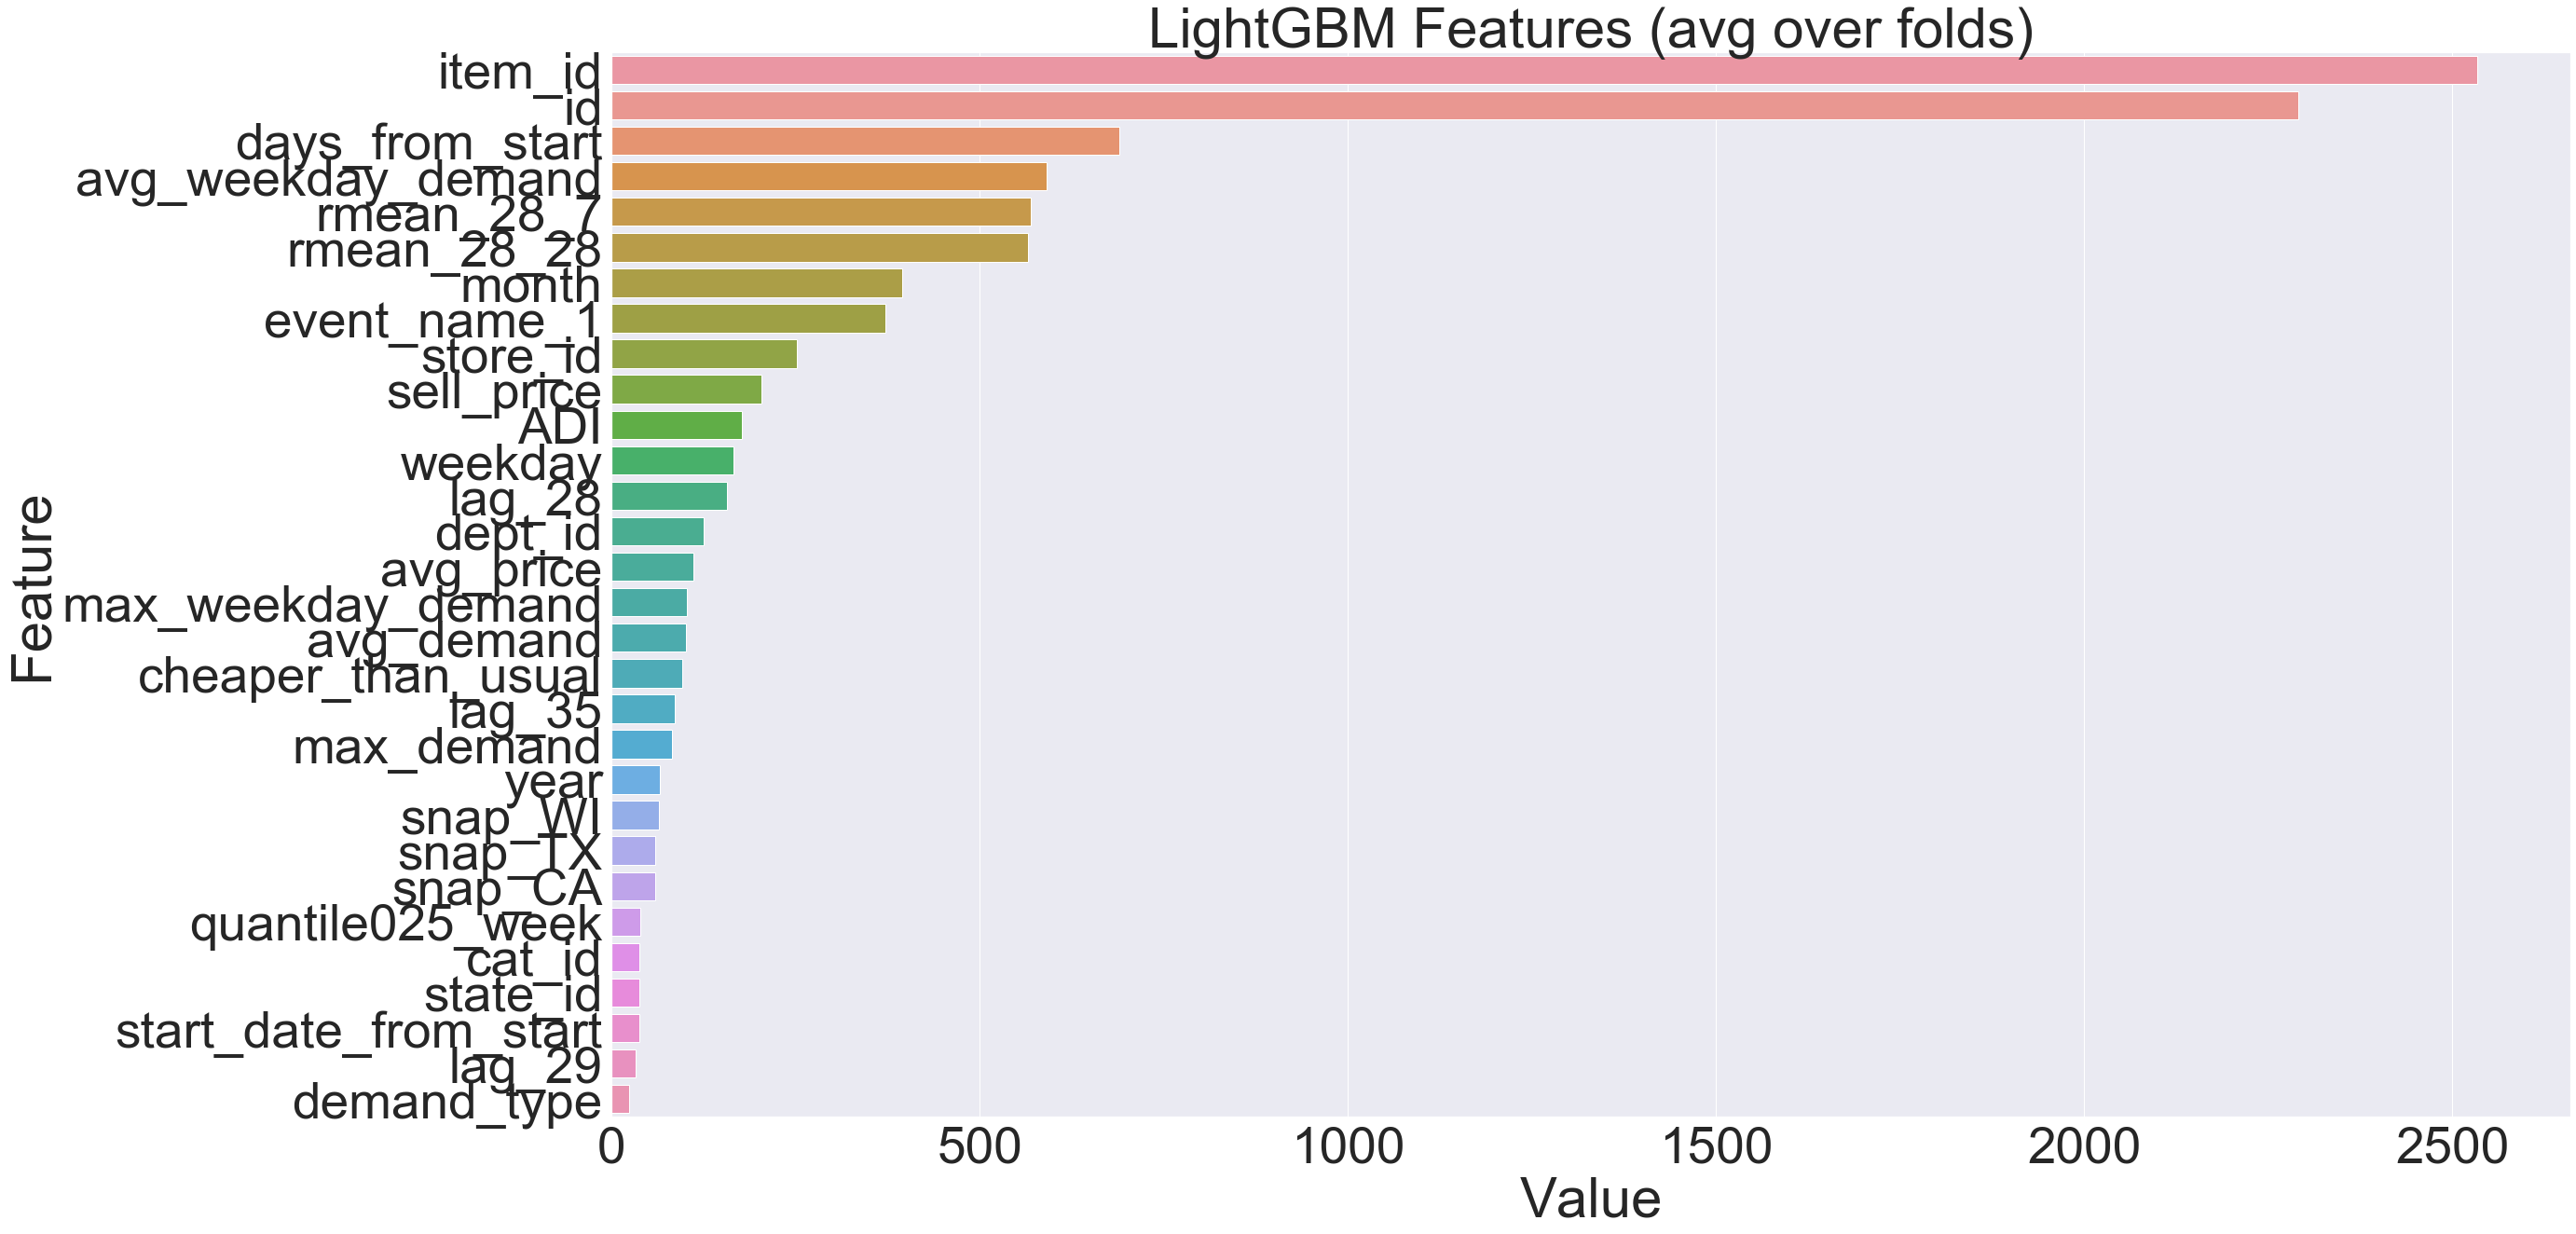

In [16]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(model, X_train[features], 30)

'item_id' and 'id' are most important features. 'days_from_start' reflect the trend of data. 

## Transform prediction

Transform predictions to the right format

In [ ]:
predictions = X_test[['id', 'days_from_start', 'items_sold']]
predictions = pd.pivot(predictions, index = 'id', columns = 'days_from_start', values = 'items_sold').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.head()

Save the submission, the features and the score to files.

In [ ]:
final.to_csv('../04_submissions/lightGBM_no_fe.csv', index = False)

In [ ]:
features = X_test.columns[~X_test.columns.isin(not_features)]
features = features.to_list()
features.append(str(val_score))
features.append(str(params['objective']))


In [ ]:
with open("../04_submissions/lgb_features_score.txt", "a") as outfile:
    outfile.write("\n".join(features))


## Score

The score of this submission is 0.58584, which is better than naive prediction.